In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

<img src="2560px-Ride_hailing_services_Wikivoyage_banner.jpg">

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

## 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

In [2]:
data = pd.read_csv("nyc_taxi_trip_duration.csv")
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


# preprocessing:

* check for missing values
* convert date columns to datetime64
* convert Yes/No to 1/0 
* check if trip duration matches the (dropoff-pickup) time

In [3]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [4]:
#NO missing values

In [5]:
data.store_and_fwd_flag.value_counts()

N    725282
Y      4040
Name: store_and_fwd_flag, dtype: int64

In [6]:
y_ix = list(data[data['store_and_fwd_flag'] == 'Y'].index)
n_ix = list(data[data['store_and_fwd_flag'] == 'N'].index)

In [7]:
data.loc[y_ix,['store_and_fwd_flag']] = 1 
data.loc[n_ix,['store_and_fwd_flag']] = 0

In [8]:
data.store_and_fwd_flag.value_counts()

0    725282
1      4040
Name: store_and_fwd_flag, dtype: int64

In [9]:
data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)
data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime)
data['check_trip_duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).map(lambda x: x.total_seconds())

In [10]:
data['check_trip_duration'].head()

0     400.0
1    1100.0
2    1635.0
3    1141.0
4     848.0
Name: check_trip_duration, dtype: float64

In [11]:
trip_diff = data[(data["check_trip_duration"] - data["trip_duration"]) > 1]

In [12]:
trip_diff.shape

(0, 12)

In [13]:
#hence all the trip duration in valid

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   729322 non-null  object        
 1   vendor_id            729322 non-null  int64         
 2   pickup_datetime      729322 non-null  datetime64[ns]
 3   dropoff_datetime     729322 non-null  datetime64[ns]
 4   passenger_count      729322 non-null  int64         
 5   pickup_longitude     729322 non-null  float64       
 6   pickup_latitude      729322 non-null  float64       
 7   dropoff_longitude    729322 non-null  float64       
 8   dropoff_latitude     729322 non-null  float64       
 9   store_and_fwd_flag   729322 non-null  object        
 10  trip_duration        729322 non-null  int64         
 11  check_trip_duration  729322 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(3), object(2)
memory usage: 66.8

# Target Exploration

In [15]:
data.trip_duration.describe()/(60*60)

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

* a trip with 538 hours is a lot and can be a outlier
* we need to transform the target using log transform

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_trip_duration', ylabel='Density'>

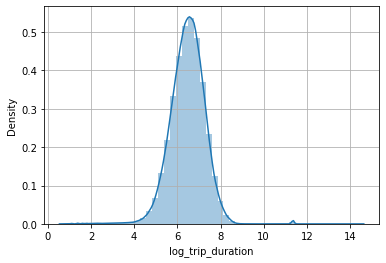

In [16]:
data["log_trip_duration"] = np.log(data['trip_duration'].values+1)
plt.grid()
sns.distplot(data["log_trip_duration"])

In [17]:
np.exp(12)/60

2712.5798569833987

* we have acheived an uniform curve
* the smooth cirve being at 6.5 which is approx. 11 minutes (exp(6.5)) trip
* outliers with 0 seconds of trips and with maximum of 2712 minutes (exp(12)) trip

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_trip_duration'>

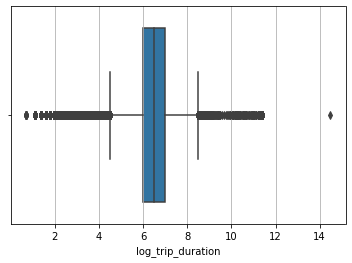

In [18]:
plt.grid()
sns.boxplot(data["log_trip_duration"])

# refer NYC_EDA and Trip_duration_eda for detailed visualization

In [19]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration'],
      dtype='object')

In [20]:
data.drop(["check_trip_duration"],axis=1,inplace=True)

# Modeling

* log trans form of trip_duration
* adding addditional features like hour,weekday,etc
*

In [22]:
data_y = np.log1p(data["trip_duration"])

In [23]:
data.loc[:,"pickup_weekday"] = data["pickup_datetime"].dt.weekday
data.loc[:,"pickup_hour"] = data["pickup_datetime"].dt.hour
data.loc[:,"pickup_minute"] = data["pickup_datetime"].dt.minute
data.loc[:,"pickup_hour_weekofyear"] = data["pickup_datetime"].dt.weekofyear
data.loc[:,"pickup_dt"] = (data["pickup_datetime"] - data["pickup_datetime"].min()).dt.total_seconds()
data.loc[:,"pickup_week_hour"] = data["pickup_weekday"]*24 + data["pickup_hour"]

/var/folders/v1/z13czw6x3l5dx84z9874l7yh0000gn/T/ipykernel_24660/1766037570.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data.loc[:,"pickup_hour_weekofyear"] = data["pickup_datetime"].dt.weekofyear


*Now we will calculate the distance and direction using following formula:


In [24]:
def haversine_dist(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2 = map(np.radians,(lat1,lng1,lat2,lng2))
    earth_radius = 6371
    lat = lat2-lat1
    lng = lng2-lng1
    d = np.sin(lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2)**2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return h

In [25]:
def direction(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2 = map(np.radians,(lat1,lng1,lat2,lng2))
    earth_radius = 6371
    lng_delta_rad = np.radians(lng2-lng1)
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) + np.sin(lat2) - np.cos(lat2) + np.sin(lat1) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y,x))

In [26]:
data['harvensine_distance'] = haversine_dist(data["pickup_latitude"].values,
                                            data["pickup_longitude"].values,
                                            data["dropoff_latitude"].values,
                                            data["dropoff_longitude"].values)

In [27]:
data['direction'] = direction(data["pickup_latitude"].values,
                                            data["pickup_longitude"].values,
                                            data["dropoff_latitude"].values,
                                            data["dropoff_longitude"].values)

In [28]:
data["pickup_latitude_round3"] = np.round(data["pickup_latitude"],3)
data["pickup_longitude_round3"] = np.round(data["pickup_longitude"],3)
data["dropoff_latitude_round3"] = np.round(data["dropoff_latitude"],3)
data["dropoff_longitude_round3"] = np.round(data["dropoff_longitude"],3)

In [29]:
data["vendor_id"] = data["vendor_id"] - 1

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        729322 non-null  object        
 1   vendor_id                 729322 non-null  int64         
 2   pickup_datetime           729322 non-null  datetime64[ns]
 3   dropoff_datetime          729322 non-null  datetime64[ns]
 4   passenger_count           729322 non-null  int64         
 5   pickup_longitude          729322 non-null  float64       
 6   pickup_latitude           729322 non-null  float64       
 7   dropoff_longitude         729322 non-null  float64       
 8   dropoff_latitude          729322 non-null  float64       
 9   store_and_fwd_flag        729322 non-null  object        
 10  trip_duration             729322 non-null  int64         
 11  log_trip_duration         729322 non-null  float64       
 12  pi

To avoid data lekage we will drop all such columns

In [31]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_minute,pickup_hour_weekofyear,pickup_dt,pickup_week_hour,harvensine_distance,direction,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id1080784,1,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,...,40,9,5157547.0,16,1.199073,-0.000101,40.779,-73.954,40.771,-73.964
1,id0889885,0,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,...,35,10,6132863.0,119,4.129111,-0.000065,40.732,-73.988,40.695,-73.995
2,id0857912,1,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,...,59,7,4471099.0,161,7.250753,0.000499,40.721,-73.997,40.775,-73.948
3,id3744273,1,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,...,44,1,380597.0,33,2.361097,0.000049,40.760,-73.962,40.781,-73.957
4,id0232939,0,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,...,42,7,4084869.0,54,4.328534,0.000293,40.708,-74.017,40.741,-73.988


In [32]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

# Train Test Split

In [33]:
df = data.copy()

In [34]:
dfy = np.log1p(df["trip_duration"])
dfy.head()

0    5.993961
1    7.003974
2    7.400010
3    7.040536
4    6.744059
Name: trip_duration, dtype: float64

In [35]:
data.drop(['dropoff_datetime','pickup_datetime','id','trip_duration','store_and_fwd_flag','log_trip_duration'],axis=1,inplace=True)

In [36]:
X_train,X_test,y_train,y_test = train_test_split(data,dfy)

Building a base model using a mean model

In [37]:
mean_pred = np.repeat(y_train.mean(),len(y_test))
sqrt(mean_squared_error(y_test,mean_pred))

0.7932941798069866

Now we will build LinearRegression, DecisionTree and later other models

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
from sklearn.model_selection import KFold

Instead of train test split we will use k-fold cross validation

In [40]:
def cv_score(model_ml,cols=data.columns,rstate=11):
    
    i = 1;
    cv_score = []
    df1 = data.copy()
    df1 = data[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    
    for train_ix,test_ix in kf.split(df1,dfy):
        
        print("\n{} of fold {} ".format(i,kf.n_splits))
        
        xtrain,ytrain = df1.loc[train_ix],dfy[train_ix]
        xtest,ytest = df1.loc[test_ix],dfy[test_ix]
        
        model = model_ml
        model.fit(xtrain,ytrain)
        train_pred = model.predict(xtrain)
        test_pred = model.predict(xtest)
        
        train_score = sqrt(mean_squared_error(ytrain,train_pred))
        test_score = sqrt(mean_squared_error(ytest,test_pred))
        
        msg = " "
        msg += ("\nTrain RMSE: {:.5f}".format(train_score))
        msg += ("\nTest RMSE: {:.5f}".format(test_score))
        
        print("{}".format(msg))
        cv_score.append(test_score)
        i += 1

    return cv_score

In [41]:
linreg = cv_score(model_ml=LinearRegression())


1 of fold 5 
 
Train RMSE: 0.65021
Test RMSE: 0.63761

2 of fold 5 
 
Train RMSE: 0.65139
Test RMSE: 0.63304

3 of fold 5 
 
Train RMSE: 0.61932
Test RMSE: 0.95689

4 of fold 5 
 
Train RMSE: 0.65042
Test RMSE: 0.64173

5 of fold 5 
 
Train RMSE: 0.64626
Test RMSE: 0.65913


In [42]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dec_tree = (DecisionTreeRegressor(min_samples_leaf=25,min_samples_split=25))
tree_score = cv_score(model_ml=dec_tree)


1 of fold 5 
 
Train RMSE: 0.37560
Test RMSE: 0.43857

2 of fold 5 


In [ ]:
dec_tree.fit(X_train,y_train)

In [ ]:
decision_tree = tree.export_graphviz(dec_tree,out_file="tree.dot",max_depth=2,filled=True,feature_names=X_train.columns)

!dot -Tpng tree.dot -o tree.png